In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 03
## FIFA dataset 


In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
print (fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'weather'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE)
EPOCHS = 101 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, 'weatherHistory.csv'))
data_df.shape

(96453, 12)

In [8]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Take care of time zones

In [9]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc=True)

In [10]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00


Apparent Temp: Feels like temp. Its mixture of temp, humidity and wind. 

In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  object             
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

In [12]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


In [13]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

Picking the numerical columns

In [14]:
num_cols = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)']

len(num_cols)

8

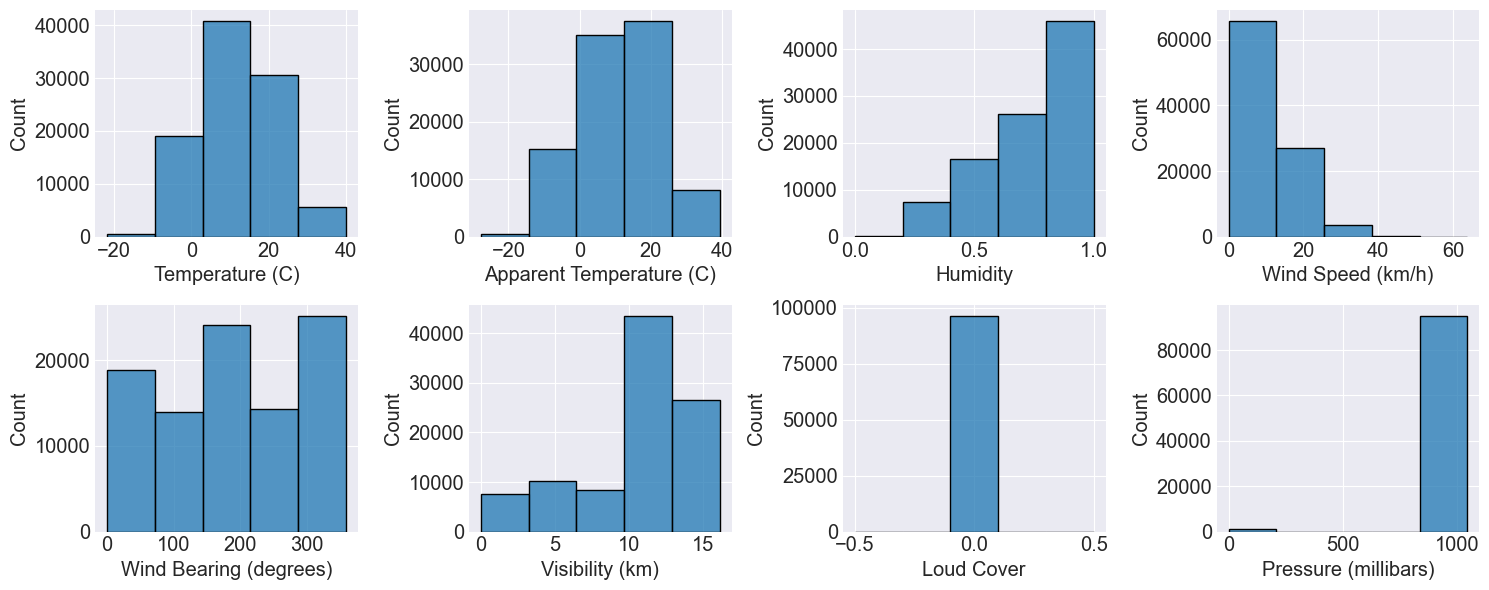

In [15]:
import seaborn as sns

fig,axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate (num_cols):
    ax = axes[count]

    sns.histplot(data_df, x = col, ax = ax, bins=5)

plt.tight_layout()

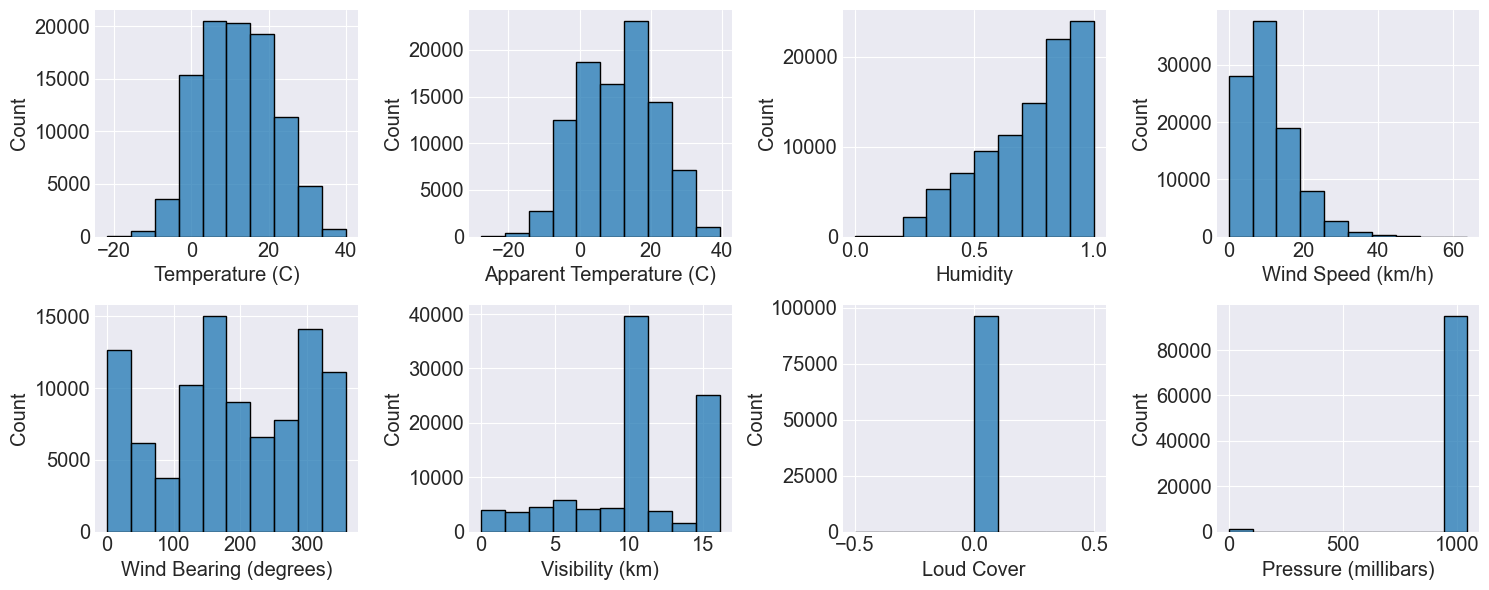

In [16]:
import seaborn as sns

fig,axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate (num_cols):
    ax = axes[count]

    sns.histplot(data_df, x = col, ax = ax, bins=10)

plt.tight_layout()

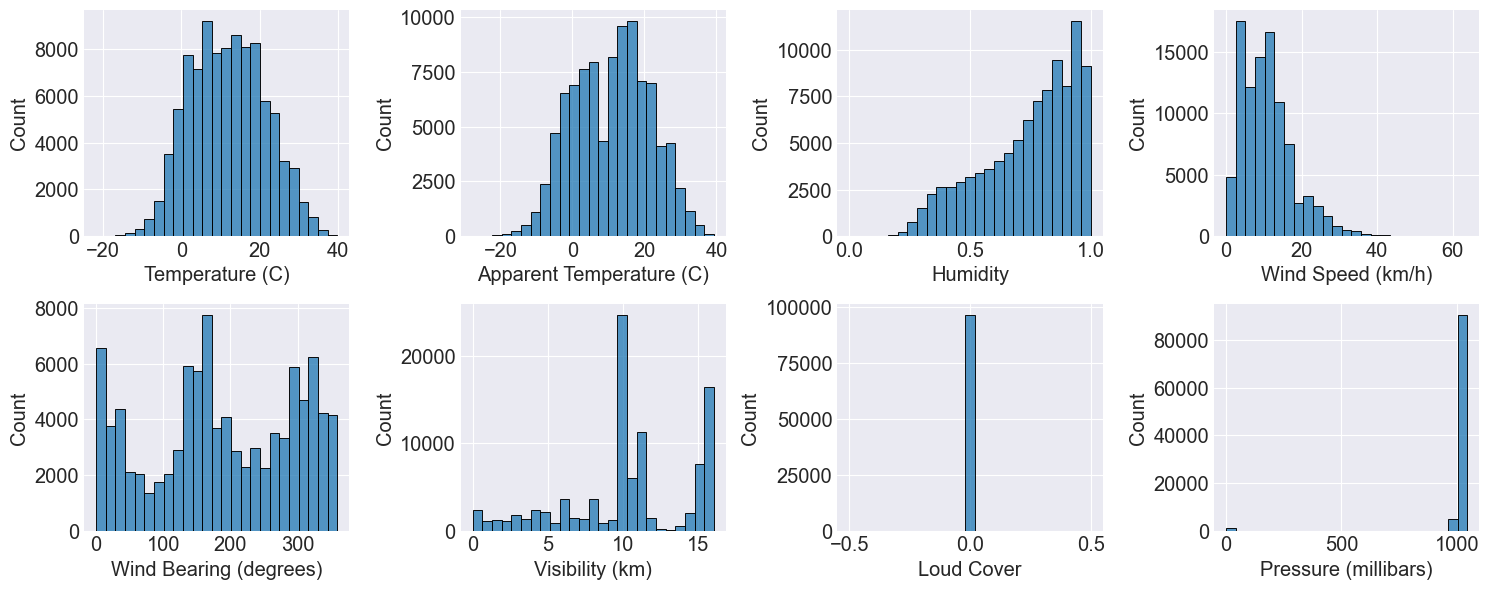

In [17]:
import seaborn as sns

fig,axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate (num_cols):
    ax = axes[count]

    sns.histplot(data_df, x = col, ax = ax, bins=25)

plt.tight_layout()

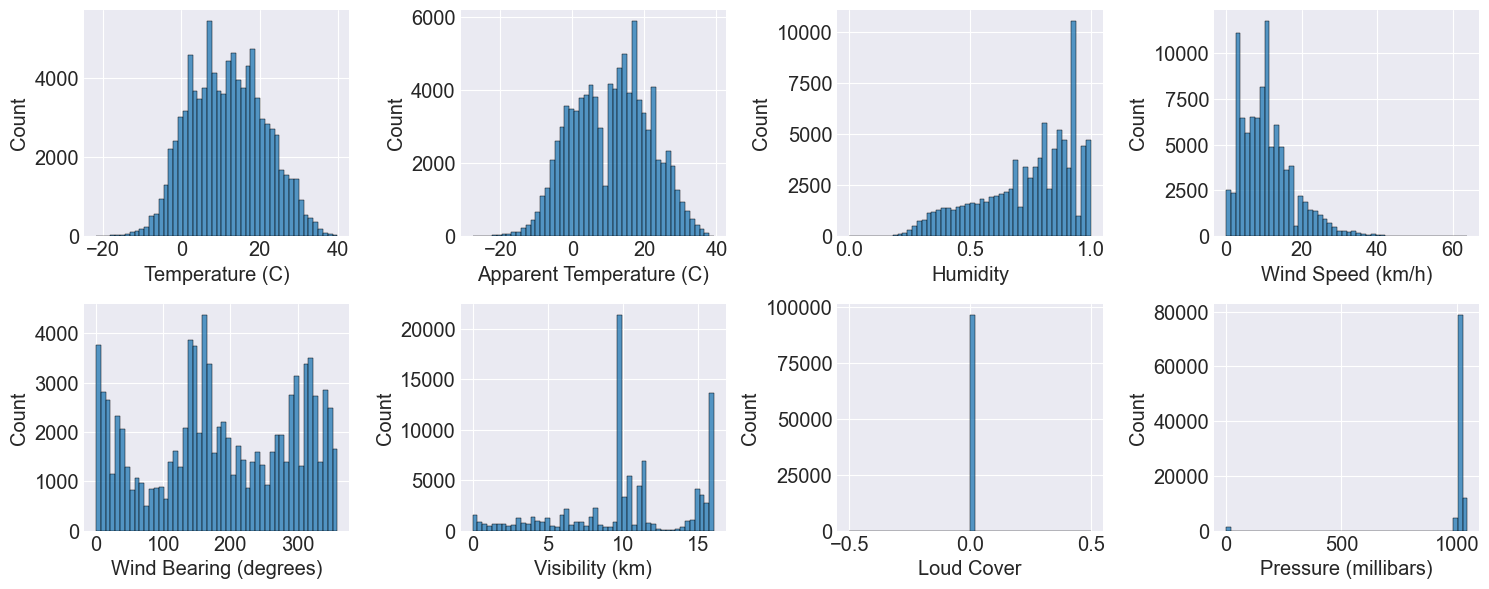

In [18]:
import seaborn as sns

fig,axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate (num_cols):
    ax = axes[count]

    sns.histplot(data_df, x = col, ax = ax, bins=50)

plt.tight_layout()

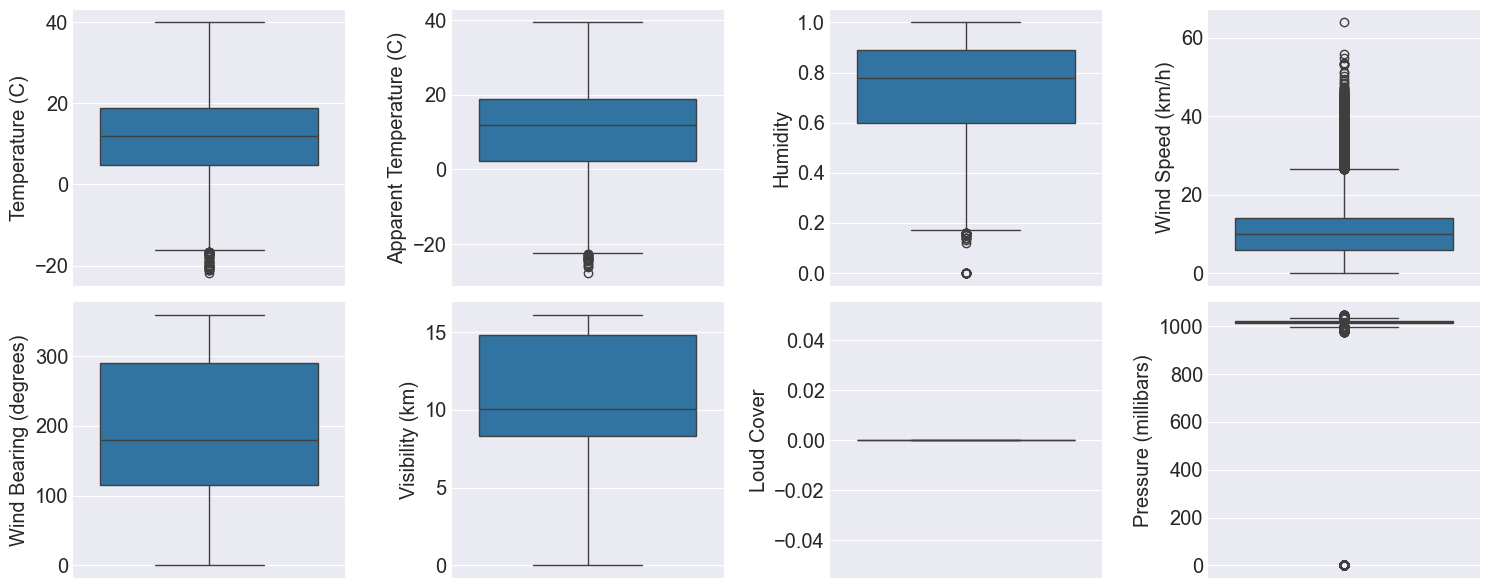

In [19]:
import seaborn as sns

fig,axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate (num_cols):
    ax = axes[count]

    sns.boxplot(data= data_df, y= col, ax = ax)

plt.tight_layout()

In [20]:
data_df[num_cols].corr()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
Temperature (C),1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,NaN,-0.005447
Apparent Temperature (C),0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,NaN,-0.000219
Humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,NaN,0.005454
Wind Speed (km/h),0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,NaN,-0.049263
Wind Bearing (degrees),0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,NaN,-0.011651
Visibility (km),0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,NaN,0.059818
Loud Cover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pressure (millibars),-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,NaN,1.000000


<Axes: >

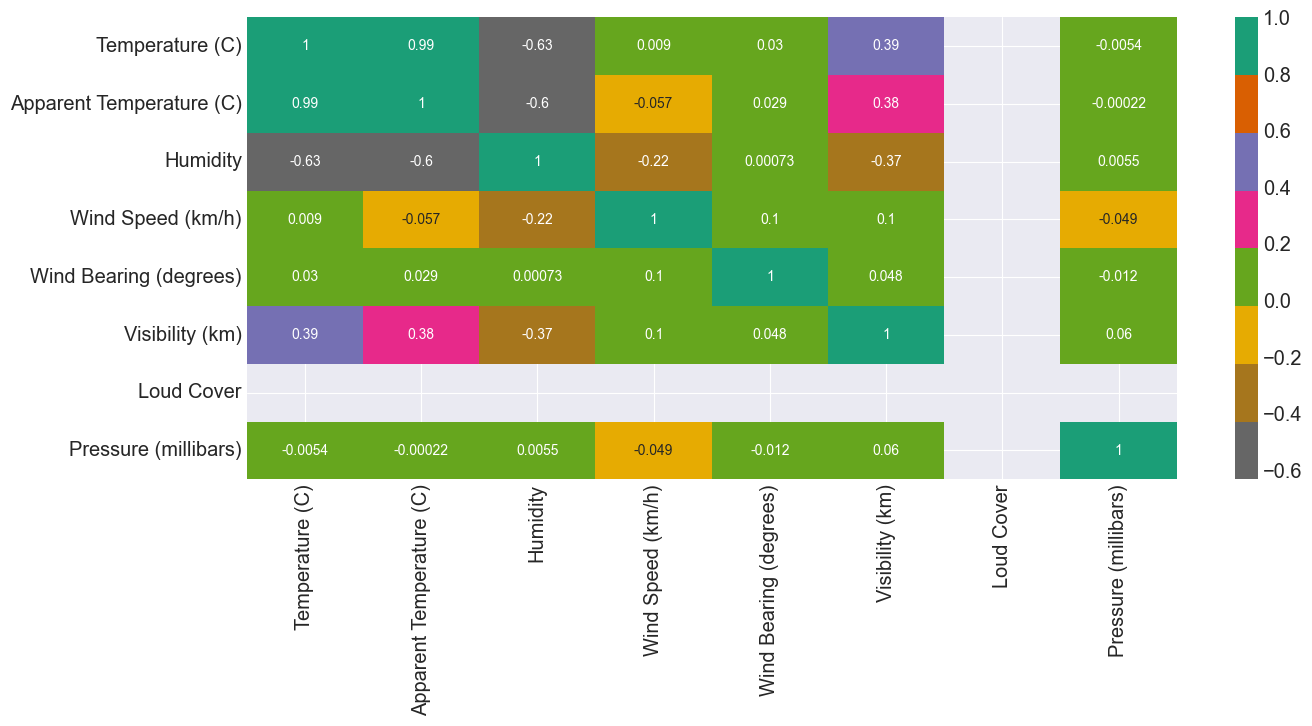

In [21]:
sns.heatmap(data_df[num_cols].corr(), annot=True, cmap='Dark2_r')

In [22]:
temp_df = data_df[['datetime', 'Temperature (C)']]
temp_df = temp_df.sort_values('datetime', ascending= True, axis=0)
temp_df = temp_df.reset_index(drop = True)
temp_df.head()


,datetime,Temperature (C)
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [23]:
temp_df = temp_df.rename({'Temperature (C)' : 'temp'}, axis= 1)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


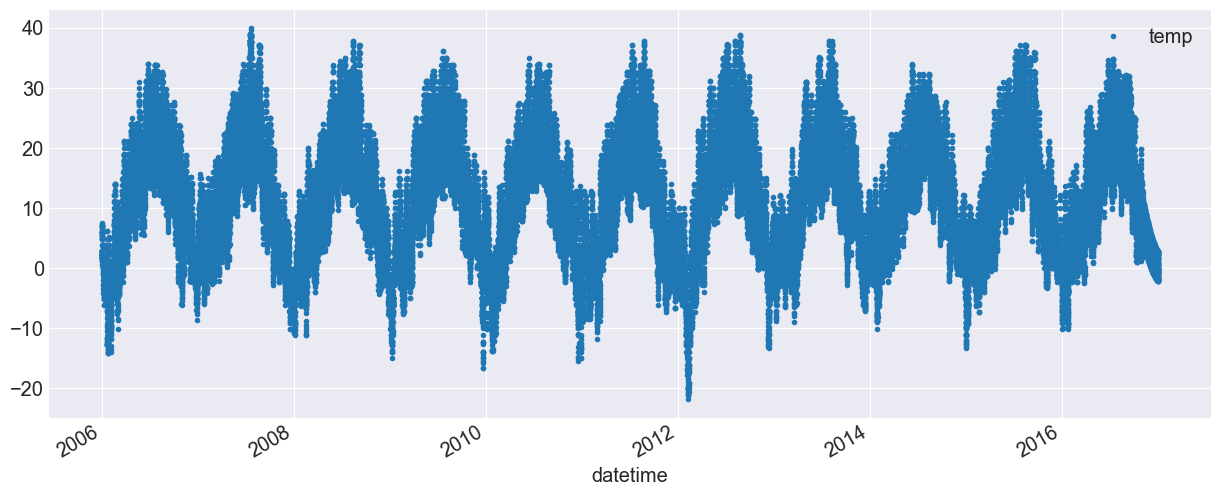

In [24]:
temp_df.plot(x= 'datetime', y= 'temp', style='.');

Model Definition

In [25]:
h_units = 100
input_shape = (1,10000)

model = tf.keras.Sequential()

model.add(tf.keras.layers.SimpleRNN(units= h_units,
                                    input_shape=input_shape,
                                    activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               1010100   
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1010201 (3.85 MB)
Trainable params: 1010201 (3.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
wax = model.get_weights()[0].shape # Weight of ax
waa = model.get_weights()[1].shape # Weight of aa
baa = model.get_weights()[2].shape # Bias of aa
way = model.get_weights()[3].shape # Weight of ay
bay = model.get_weights()[4].shape # Bias of ay

wax, waa, baa, way, bay

((10000, 100), (100, 100), (100,), (100, 1), (1,))

In [28]:
temp_df.head(30)

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333
5,2006-01-01 04:00:00+00:00,1.205556
6,2006-01-01 05:00:00+00:00,2.222222
7,2006-01-01 06:00:00+00:00,2.072222
8,2006-01-01 07:00:00+00:00,2.200000
9,2006-01-01 08:00:00+00:00,2.733333


In [29]:
time_step = 24

y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_idx.shape

(4018,)

In [30]:
y_df = temp_df.iloc[y_idx]
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [31]:
y_df.shape

(4018, 2)

In [32]:
y_df.shape[0] * time_step

96432

In [33]:
X_df = temp_df.iloc[range(len(y_df) * time_step)]
X_df.shape

(96432, 2)

In [34]:
X_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [35]:
X = np.reshape(X_df['temp'].to_numpy(), (y_df.shape[0], time_step))
X.shape

(4018, 24)

In [36]:
X = X[:, :23]
X.shape

(4018, 23)

Input shape expectations = `[batch, timestep, feature]`

In [37]:
X = np.reshape(X, [X.shape[0], X.shape[1], 1])
X.shape

(4018, 23, 1)

In [38]:
split = int(y_df.shape[0] * (1 - TEST_SIZE))
X_train = X[:split]
X_test = X[split:]

y_train = y_df['temp'].to_numpy()[:split]
y_test = y_df['temp'].to_numpy()[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [39]:
h_units = 256
input_shape = (time_step-1, 1)

model = tf.keras.Sequential()

model.add(tf.keras.layers.SimpleRNN(units= h_units,
                                    input_shape=input_shape,
                                    activation='tanh'))

model.add(tf.keras.layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', 
              metrics = [tf.keras.metrics.RootMeanSquaredError()],
              loss='mean_squared_error')

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 256)               66048     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 66305 (259.00 KB)
Trainable params: 66305 (259.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
history = model.fit(X_train, y_train, 
                    validation_data = [X_test, y_test],
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS, 
                    verbose = 2)

Epoch 1/101

101/101 - 4s - loss: 11.3993 - root_mean_squared_error: 3.3763 - val_loss: 1.0672 - val_root_mean_squared_error: 1.0331 - 4s/epoch - 35ms/step
Epoch 2/101
101/101 - 2s - loss: 1.5810 - root_mean_squared_error: 1.2574 - val_loss: 0.8889 - val_root_mean_squared_error: 0.9428 - 2s/epoch - 17ms/step
Epoch 3/101
101/101 - 1s - loss: 1.3083 - root_mean_squared_error: 1.1438 - val_loss: 0.8158 - val_root_mean_squared_error: 0.9032 - 1s/epoch - 15ms/step
Epoch 4/101
101/101 - 2s - loss: 1.2379 - root_mean_squared_error: 1.1126 - val_loss: 0.8122 - val_root_mean_squared_error: 0.9012 - 2s/epoch - 15ms/step
Epoch 5/101
101/101 - 2s - loss: 1.3188 - root_mean_squared_error: 1.1484 - val_loss: 0.7736 - val_root_mean_squared_error: 0.8795 - 2s/epoch - 17ms/step
Epoch 6/101
101/101 - 2s - loss: 1.1803 - root_mean_squared_error: 1.0864 - val_loss: 0.9056 - val_root_mean_squared_error: 0.9516 - 2s/epoch - 16ms/step
Epoch 7/101
101/101 - 2s - loss: 1.0961 - root_mean_squared_error: 1.0469 

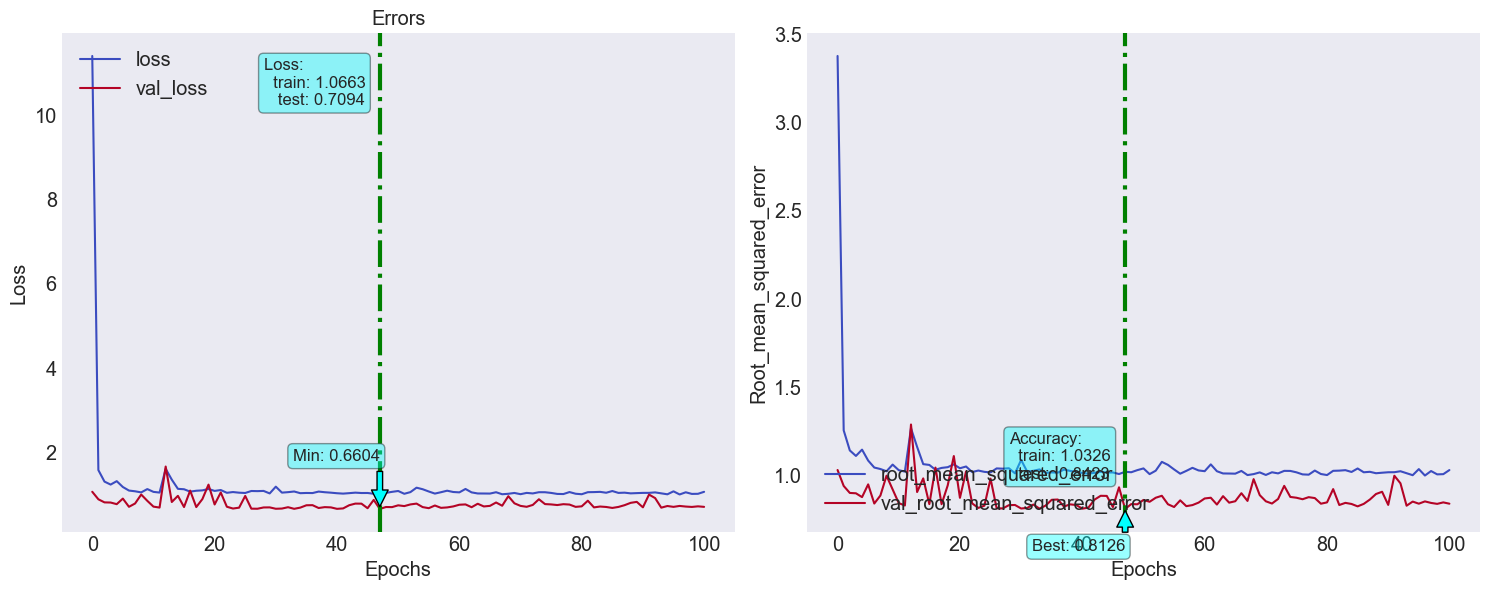

In [42]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [43]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
47,1.046243,1.02286,0.660385,0.812641


In [44]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_pred = np.append(y_train_pred, y_test_pred)

y_pred.shape

26/26 [==============================] - 0s 7ms/step


(4018,)

In [45]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,4.844682
48,2006-01-02,1.694444,1.423695
72,2006-01-03,2.200000,1.892171
96,2006-01-04,1.666667,1.733654
120,2006-01-05,1.805556,2.262236


#### How we can make it more Accurate ?

- Add more Fatures
- Add more Data (Interpret it Hourly basis or subgroups as Hourly)

<Axes: xlabel='datetime'>

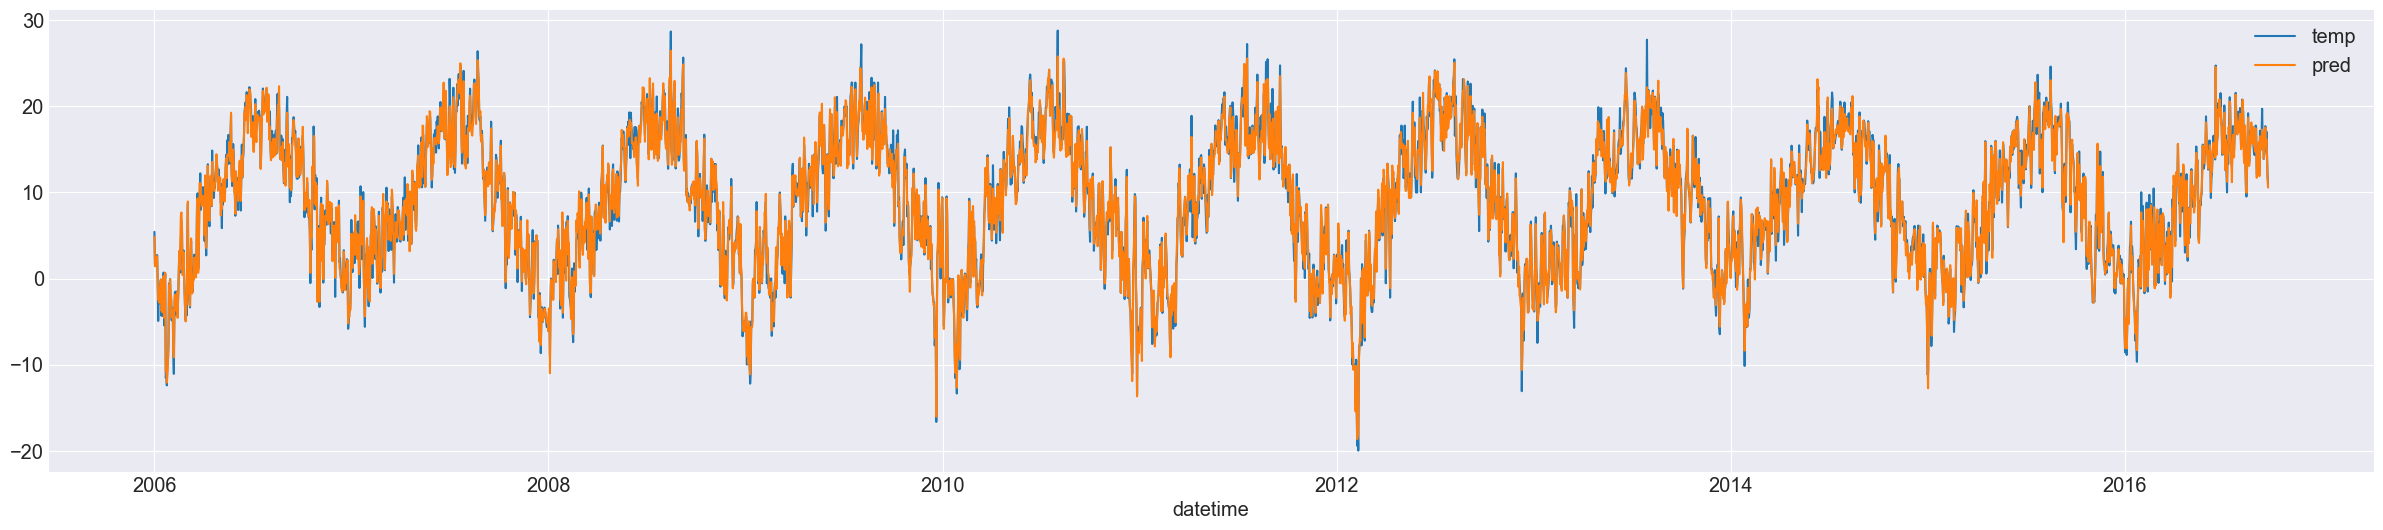

In [46]:
fig, ax = plt.subplots(figsize = (30,6))

res_df[:-100].plot(x = 'datetime', y = ['temp', 'pred'], ax = ax)